# Regularization
Regularization reduces overfitting by lowering the complexity of the neural network. There are many different techniques and algorithms for regularization, some of which we will explore here.

## L1 / L2 regularization
L1 and L2 regularization crop up in minimum entropy methods in physics. L1 is also known as *Least Absolute Shrinkage and Selection Operator* (Lasso), and L2 is commonly called *Ridge Regression*. [Terence Parr](https://explained.ai/regularization/L1vsL2.html) provides a good and in-depth comparison of the methods.

Both algorithms function by adding a penalty to a regularizer: consider the Lagrangian (cost/error function)
$$
\tilde{\mathcal{L}} \left( W^l \right) = \mathcal{L} \left( W^l \right) + \alpha R \left( W^l \right),
$$
as a function of weights, where $\tilde{\mathcal{L}} \left( W^l \right)$ is the regularized Lagrangian, $R \left( W^l \right)$ is the regularizer term, and $\alpha$ the Lagrange multiplier (essentially a hyper-parameter).

For L1, we take the [L1 norm](https://en.wikipedia.org/wiki/Norm_(mathematics)#Euclidean_norm) of the weights for $R \left( W^l \right)$, whereas in L2 we use the L2 norm.

The weights are then backpropagated
$$
\nabla_{W^l} \tilde{\mathcal{L}} \left( W^l \right) = \nabla_{W^l} \left[ \mathcal{L} \left( W^l \right) + \alpha R \left( W^l \right) \right]
$$
accordingly.

We will discuss the differences between the methods in more detail in a moment: let us illustrate them first by example.

## Regularization Illustration
We will use the miles-per-gallon data set, and `sklearn` for regularization.

In [1]:
import pandas as pd

df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/auto-mpg.csv",
    na_values=['NA', '?']
)
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.0,2625,18.6,82,1,ford ranger


We quickly handle the missing values and construct vectors:

In [2]:
from sklearn.model_selection import train_test_split

df['horsepower'] = df['horsepower'].fillna(
    df['horsepower'].median()
)

x_cols = list(df.columns.drop('mpg').drop('name'))

x = df[x_cols].values
y = df['mpg'].values

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.25, 
    random_state=414141
)

And we define a helper function for evaluating coefficients of regression:

In [3]:
%matplotlib inline
import IPython.display

def report_coef(names, coef, intercept):
    r = pd.DataFrame(
        {'coef': coef, 'positive': coef >= 0},
        index=names
    )
    r = r.sort_values(by=['coef'])
    
    # pretty print
    IPython.display.display(r)
    print(f"Intercept = {intercept}")
    
    r['coef'].plot(
        kind='barh',
        color=r['positive'].map(
            {True: 'b', False: 'r'}
        )
    )

### Linear regression
L1 and L2 regularization first introduced for [linear regression](https://en.wikipedia.org/wiki/Linear_regression) algorithms: we use a `sklearn` linear regression class to solve the constrained problem:

Score (RMSE) = 2.986045960294155


,coef,positive
cylinders,-0.089544,False
horsepower,-0.008501,False
weight,-0.007060,False
displacement,0.017831,True
acceleration,0.227142,True
year,0.789679,True
origin,1.494226,True


Intercept = -23.43290145870238


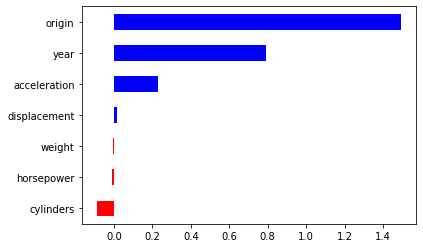

In [4]:
from sklearn import linear_model
import sklearn
import numpy as np

regressor = linear_model.LinearRegression()

regressor.fit(x_train, y_train)

reg_pred = regressor.predict(x_test)

score = np.sqrt(sklearn.metrics.mean_squared_error(
    reg_pred,
    y_test
))
print(f"Score (RMSE) = {score}")

report_coef(
    x_cols,
    regressor.coef_,
    regressor.intercept_
)

### L1: Lasso regularizer
L1 applies the regularizer term
$$
R \left( w^t_{ij} \right) = \sum_i\sum_j \left\vert w^t_{ij} \right\vert,
$$
which can be visualized as a diamond with corners on the axes over the origin of the $x,y$ plane. It's use consequently is to create sparsity in the network, and will favour pulling weights close to zero, such that it is essentially 'dropped' from the network.

Fig 1: Symmetric loss of L1: green points represent random loss functions with resulting regularized coefficients being zero, and blue represents no coefficient being zero. Image taken from [Terence Parr](https://explained.ai/regularization/L1vsL2.html).
<img src="https://explained.ai/regularization/images/l1-symmetric-cloud.png" alt="L1" width="400"/>

*Feature selection* is a byproduct of sparse neural networks; *features* are the values that the training set provides to the inputs. If a weight on a neuron reaches zero, the network considers this feature to be redundant in predicting the outcome. Consequently, L1 can be used to help a NN drop unecessary features.

We can implement this as such for linear regression:

Score (RMSE) = 2.986045960294155


,coef,positive
horsepower,-0.007625,False
weight,-0.007026,False
cylinders,-0.000000,True
displacement,0.013997,True
acceleration,0.195914,True
year,0.781452,True
origin,1.209219,True


Intercept = -21.805924107937667


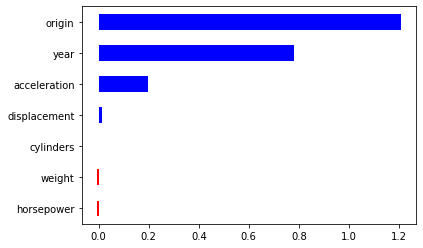

In [5]:
l1_regressor = linear_model.Lasso(
    random_state=414141,
    alpha=0.1
)

l1_regressor.fit(x_train, y_train)

l1_pred = regressor.predict(x_test)

score = np.sqrt(sklearn.metrics.mean_squared_error(
    l1_pred,
    y_test
))
print(f"Score (RMSE) = {score}")

report_coef(
    x_cols,
    l1_regressor.coef_,
    l1_regressor.intercept_
)

This regression algorithm determined that the number of cylinders is an unimportant feature.

#### Hyper parameter
Let's examine how the model score changes as we adjust the Lagrange multiplier $\alpha$. We will train an L1 model on our data, and compute the [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html), which is a folded train-test model seperating the data set into $k$ folds, training on $k-1$, and testing on the remaining to better estimate how the model generalises. The `sklearn` implementation calculates MSE and averages them over the $k$ folds, such that the returned value is a confidence measure -- a value close to 1 is desired.

In [6]:
import sklearn.model_selection

lasso = linear_model.Lasso(random_state=414141)
alphas = np.logspace(-8, 8, 100) # Lagrange multipliers

scores = []
scores_std = []

n_folds = 3

for alpha in alphas:
    lasso.alpha = alpha
    
    t_scores = sklearn.model_selection.cross_val_score(
        lasso, 
        x, 
        y, 
        cv=n_folds,
        n_jobs=1
    )
    scores.append(np.mean(t_scores))
    scores_std.append(np.std(t_scores))
    
scores, scores_std = np.array(scores), np.array(scores_std)

Next we visualise this data:

(1e-08, 100000000.0)

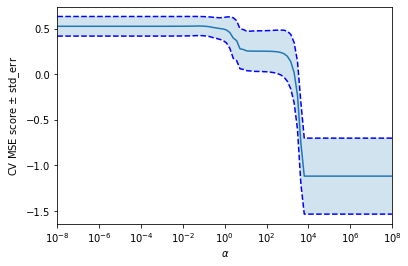

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()

# log plot on x axis
plt.semilogx(alphas, scores)

std_err = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_err, 'b--')
plt.semilogx(alphas, scores - std_err, 'b--')

# fill error margins
plt.fill_between(
    alphas, 
    scores + std_err, 
    scores - std_err,
    alpha= 0.2
)

plt.ylabel(r"CV MSE score $\pm$ std_err")
plt.xlabel(r'$\alpha$')
plt.xlim([alphas[0], alphas[-1]])

### L2: Ridge regularization
L2, or *ridge* regularization, sets the regularizer term to
$$
R\left( w^l_{ij} \right) = \sum_i\sum_j \left\vert\left\vert w^t_{ij} \right\vert\right\vert^2,
$$
and can be pictures as a circlular attractor.

Fig 2: Symmetric loss of L2: same colour coding as above, except orange represents points where a single parameter was 0. Image taken from [Terence Parr](https://explained.ai/regularization/L1vsL2.html).
<img src="https://explained.ai/regularization/images/l2-symmetric-cloud.png" alt="L1" width="400"/>

L2 is used when low weight values are desired, reducing the chance of model overfitting. Generally, L2 produces better results than L1, however is not as efficient at feature removal.

We can implement an example with `sklearn`:

Score (RMSE) = 2.9859948742479214


,coef,positive
cylinders,-0.089277,False
horsepower,-0.008487,False
weight,-0.007061,False
displacement,0.017817,True
acceleration,0.227122,True
year,0.789661,True
origin,1.492834,True


Intercept = -23.428556602124967


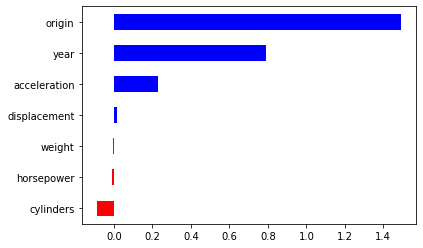

In [8]:
l2_regressor = linear_model.Ridge(
    alpha=0.1
)

l2_regressor.fit(
    x_train,
    y_train
)

l2_pred = l2_regressor.predict(x_test)

score = np.sqrt(sklearn.metrics.mean_squared_error(
    l2_pred,
    y_test
))
print(f"Score (RMSE) = {score}")

report_coef(
    x_cols,
    l2_regressor.coef_,
    l2_regressor.intercept_
)

### ElasticNet
As a final example, let us consider both L1 and L2 regularizations applied -- this is known as ElasticNet, and applies a Lagrange multiplier for each term:

Score (RMSE) = 2.980003613254606


,coef,positive
cylinders,-0.013111,False
weight,-0.007101,False
horsepower,-0.005576,False
displacement,0.014282,True
acceleration,0.218707,True
year,0.783798,True
origin,1.171878,True


Intercept = -22.2527951291034


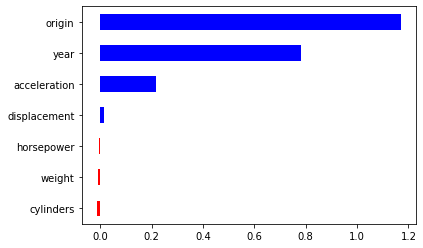

In [9]:
en_regressor = linear_model.ElasticNet(
    alpha=0.1,
    l1_ratio=0.1
)

en_regressor.fit(
    x_train,
    y_train
)

en_pred = en_regressor.predict(x_test)

score = np.sqrt(sklearn.metrics.mean_squared_error(
    en_pred,
    y_test
))
print(f"Score (RMSE) = {score}")

report_coef(
    x_cols,
    en_regressor.coef_,
    en_regressor.intercept_
)